# Praktikum 3: Softmax, Regularisierung, Momentum und Batchsize
## 4. Eigener Datensatz
Suchen Sie sich eine verfügbare PyTorch MLP-Implementierung für einen Datensatz heraus, der Sie besonders interessiert. Reproduzieren Sie die Ergebnisse lokal, auf colab oder RosettaHub. Ist die Implementierung vergleichbar mit der hier gegebenen IMDB Implementierung? Wo unterscheidet sich diese und ggf. warum? Wie verändern Sich die Ergebnisse, wenn Sie bestimmte Hyperparameter verändern?

Quelle: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md


In [10]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

from matplotlib import pyplot as plt
import numpy as np
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
import pandas as pd

Unterschied zu IMDB Implementierung:
- hier feste Neuronenanzahl je Layer, andere werden erst bei Initialisierung festgelegt
- vorher flatten() ausgeführt, bei uns wird x_train vorher in torch umgewandelt
- ReLU statt sigmoid verwendet
- keine Aktivierungsfunktion im letzten Layer

In [11]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      nn.ReLU(), # original
      # nn.Sigmoid(), 
      nn.Linear(64, 32),
      nn.ReLU(), # original
      # nn.Sigmoid(), 
      nn.Linear(32, 10),
      # nn.Softmax() #selbst hinzugefügt
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

Unterschied zu IMDB Implementierung:
- Funktion zur Erstellung der batches selbst definiert
- Es werden keine Testdaten verwendet

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [12]:
# Prepare CIFAR-10 dataset
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

Files already downloaded and verified


Unterschied zu IMDB Implementierung:
- Adam statt SGD optimizer
- beide verwenden CrossEnropyLoss

In [13]:
# Initialize the MLP
mlp = MLP()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)# vorher 1e-4

In [14]:
# summary über model
from torchinfo import summary
summary(mlp)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       196,672
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       2,080
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 199,082
Trainable params: 199,082
Non-trainable params: 0

Unterschied zu IMDB Implementierung:
- kaum Unterschied zur IMDB Implementierung
- Epochenanzahl festgelegt und nicht variabel

In [15]:
# loss_list = [] 
# # Run the training loop
# for epoch in range(0, 5): # 5 epochs at maximum

#     # Print epoch
#     print(f'Starting epoch {epoch+1}')

#     # Set current loss value
#     current_loss = 0.0

#     # Iterate over the DataLoader for training data
#     for i, data in enumerate(trainloader, 0):
        
#         # Get inputs
#         inputs, targets = data
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Perform forward pass
#         outputs = mlp(inputs)
        
#         # Compute loss
#         loss = loss_function(outputs, targets)
        
#         # Perform backward pass
#         loss.backward()
        
#         # Perform optimization
#         optimizer.step()
        
#         loss_list.append(loss.item())

#         # Print statistics
#         current_loss += loss.item()
#         if i % 500 == 499:
#             print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
#             current_loss = 0.0

#     # Process is complete.
# print('Training process has finished.')

In [16]:
loss_list = [] 
loss_dict = dict()
correct = []

accuracy = MulticlassAccuracy()
precision = MulticlassPrecision()
recall = MulticlassRecall()

accuracy_list = []

# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum

    accuracy.reset()
    precision.reset()
    recall.reset()

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss with onehot encoded values
        loss = loss_function(outputs,targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_list.append(loss.item())

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            if epoch == 0:
                loss_dict[i] = [current_loss/500]
            else:
                loss_dict[i].append(current_loss/500)
            current_loss = 0.0
    
        accuracy.update(torch.argmax(outputs, dim=0), targets)
        precision.update(torch.argmax(outputs, dim=0), targets)
        recall.update(torch.argmax(outputs, dim=0), targets)
        
        # accuracy.compute() returns accuracy value from all seen data
    print(f'Metriken Epoche {epoch+1}: Accuracy - {accuracy.compute()}, Precision - {precision.compute()}, Recall - {recall.compute()}')
    
    accuracy_list.append(accuracy.compute())
    
    # Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch   500: 2.229
Loss after mini-batch  1000: 2.099
Loss after mini-batch  1500: 2.021
Loss after mini-batch  2000: 1.980
Loss after mini-batch  2500: 1.939
Loss after mini-batch  3000: 1.916
Loss after mini-batch  3500: 1.929
Loss after mini-batch  4000: 1.897
Loss after mini-batch  4500: 1.897
Loss after mini-batch  5000: 1.843
Metriken Epoche 1: Accuracy - 0.11661999672651291, Precision - 0.11661999672651291, Recall - 0.11661999672651291
Starting epoch 2
Loss after mini-batch   500: 1.853
Loss after mini-batch  1000: 1.831
Loss after mini-batch  1500: 1.829
Loss after mini-batch  2000: 1.827
Loss after mini-batch  2500: 1.794
Loss after mini-batch  3000: 1.821
Loss after mini-batch  3500: 1.792
Loss after mini-batch  4000: 1.786
Loss after mini-batch  4500: 1.794
Loss after mini-batch  5000: 1.757
Metriken Epoche 2: Accuracy - 0.12285999953746796, Precision - 0.12285999953746796, Recall - 0.12285999953746796
Starting epoch 3
Loss after mini-batch  

Accuracy ist etwas besser als Zufall (0.1).

In [17]:
# #plot changing loss for each epoch
# labels = range(1, len(loss_dict[499])+1)
# plt.plot(loss_dict.keys(), loss_dict.values(),label = labels)
# plt.legend(title = 'epoch')
# plt.title('Durchschnittlicher Loss aus 500 Trainingsschritten \nje Epoche')

Text(0.5, 1.0, 'Gleitender Durchschnitt des Loss je Epoche')

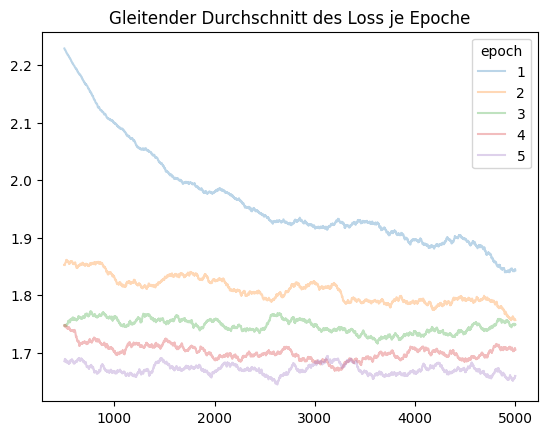

In [18]:
# Damit Grafik mit jeder Epochenanzahl funktioniert
epoch_count = len(loss_list) // 5000  # Ganzzahldivision
loss_list_chunked = np.array_split(loss_list, epoch_count)

# Transponieren, da über Spalten nicht Zeilen gemittelt werden soll
t_average = pd.DataFrame(loss_list_chunked).T.rolling(window=500).mean().T

for i in range(epoch_count):
    plt.plot(range(1,5001), t_average.iloc[i,:],label = i+1, alpha=0.3)
plt.legend(title = 'epoch')
plt.title('Gleitender Durchschnitt des Loss je Epoche')